### B decay model

In [ ]:
# Integrate cos_theta
from sympy import * 
a_l, x = symbols('a_l x')
integrate(a_l - a_l * x**2, (x,-1,1))

In [ ]:
from sympy import * 
from sympy.solvers import solve
from scipy import signal
import numpy as np
import math 
import sys
import scipy.integrate as integrate
import decimal
from matplotlib import pyplot as plt
np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
import seaborn as sns

def lambda_(q):
    return M_B**4 + M_K**4 + q**4 - 2 * (M_B**2 * M_K**2 + M_B**2 * q**2 + M_K**2 * q**2)

def f(q, K, M, Gamma, Gamma_channel):
    C = coeff(Gamma_channel)
    return (K * C) / ((np.square(q) - M**2)**2 + Gamma**2 * M**2)

def integrand(u, M, Gamma):
    return  (1 / ((u - M**2)**2 + Gamma**2 * M**2))

def sm_integrand(q, cos_theta):
    return  a_l(q) - a_l(q) * cos_theta**2

def sm(q, cos_theta):    
    return  a_l(q) - a_l(q) * cos_theta**2

def coeff(Gamma_channel):
    return (9 * math.pi * Gamma_channel) / (alpha_e**2)

def a_l(q):
    l = lambda_(q)
    frho = f(q, K_rho, M_rho, Gamma_rho, Gamma_rho_e)
    fphi = f(q, K_phi, M_phi, Gamma_phi, Gamma_phi_e)
    fpsi = f(q, K_psi, M_psi, Gamma_psi, Gamma_psi_e)
    F = frho + fphi + fpsi
    F = np.array(F, dtype='float64')
    return (F**2 * 8 * l**(3/2) * G_F**2 * alpha_e**2 * abs(V_tb * V_ts)**2) / (512 * math.pi**5 * M_B**3)   

def K(M, Gamma, Gamma_channel):
    K = symbols('K')
    C = coeff(Gamma_channel)
    I = integrate.quad(integrand, -np.inf, np.inf, args=(M, Gamma))
    return solve(K * C * I[0] - 1, K)[0]

def Ksm():
    K = symbols('K')
    I = integrate.dblquad(sm_integrand, 0, np.inf,-1,1)
    return solve(K *  I[0] - 1, K)[0]

def metropolis_hastings(p, iter=10000000):
    x, y = 0., 0.
    samples = np.zeros((iter - 10**3, 2))
    scale = 0.2
        
    for i in range(iter):
        x_star, y_star = np.array([x, y]) + scale * np.random.normal(size=2)
        if y_star <= 1 and y_star >= -1 and x_star >= 0:  
            if (not math.isnan(p(x_star, y_star)) and 
                math.log(np.random.rand()) < p(x_star, y_star) - p(x, y) 
                and p(x_star, y_star) - p(x, y) > 0):
                x, y = x_star, y_star
                
            if i > 10**3:
                samples[i] = np.array([x, y])

    return samples

# constants
alpha_e = 1/137

# rho meson
M_rho = 0.77
Gamma_rho = 0.150
Gamma_rho_e = 7 * 10**(-6)

# phi meson
M_phi = 1.020
Gamma_phi = 4.26 * 10**(-3)
Gamma_phi_e = 1.25 * 10**(-6)

#psi meson
M_psi = 3.096
Gamma_psi = 92.9 * 10**(-6)
Gamma_psi_e = 5.55 * 10**(-6)

G_F = 1.1663 * 10**(-5)
M_B = 5366.79 * 10**(-3) # Strange B meson
M_K = 497.648 * 10**(-3) # Neutral kaon ds_bar

V_tb = 1.019
V_ts = 39.4 * 10**(-3)



In [ ]:
%matplotlib

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

K_rho = K(M_rho, Gamma_rho, Gamma_rho_e)
K_phi = K(M_phi, Gamma_phi, Gamma_phi_e)
K_psi = K(M_psi, Gamma_psi, Gamma_psi_e)

K_sm = Ksm();

samples = metropolis_hastings(sm, iter=1000)
sns.jointplot(samples[:, 0], samples[:, 1])


### Load data

#### Computation of overlap with KL divergence

In [ ]:
def computeKL(mu1, mu2, sigma1, sigma2, ax):    
    v1 = np.random.normal(mu1, sigma1, 100000)
    v2 = np.random.normal(mu2, sigma2, 100000)

    count, bins, ignored = ax.hist(v1, 30, density=True, color='green')
    count2, bins2, ignored = ax.hist(v2, 30, density=True, color='orange')   
    
    minValue = min(min(bins),min(bins2))
    maxValue = max(max(bins),max(bins2))
    x = np.linspace(minValue, maxValue, 1000)
    y1 = 1/(sigma1 * np.sqrt(2 * np.pi)) * np.exp( - (x - mu1)**2 / (2 * sigma1**2) )
    y2 = 1/(sigma2 * np.sqrt(2 * np.pi)) * np.exp( - (x - mu2)**2 / (2 * sigma2**2) )
    ax.plot(x, y1, linewidth=2, color='r')
    ax.plot(x, y2 , linewidth=2, color='b')
    
    return entropy(y1, y2)
    
def computeOverlap(df1, df2):
    result = [[mu1,mu2,sigma1,sigma2] for mu1,mu2,sigma1,sigma2 in zip(df1['BinValue'],df2['BinValue'], df1['ErrorPlus'],df2['ErrorPlus'])]
    fig = plt.figure()
    fig.set_figheight(25)
    fig.set_figwidth(15)
    index = 1
    kls = []
    
    for mu1,mu2,sigma1,sigma2 in result:
        ax = fig.add_subplot(len(result), 2, index)        
        index = index + 1
        kl = computeKL(mu1, mu2, sigma1, sigma2, ax)
        ax.set_title('Kullback-Liebler divergence: {}'.format(kl))
        kls.append(kl)
    plt.show()
    return np.mean(kls)   
    

def experiment1():
    EXPDIR = 'data\experimental'
    DATADIR = 'data\models\observables'
    MODELSDIR = 'data\models'
    filename = 'models.txt'
    
    models = pd.read_csv(os.path.join(MODELSDIR, filename))  
    
    for i in models.index:
        model = models.iloc[[i]]
        
        modelName = model['Name'][i]
        C9 = model['C9'][i]
        C10 = model['C10'][i]
        fig = plt.figure()
        fig.set_figheight(15)
        fig.set_figwidth(15)
        fig.subplots_adjust(wspace=0.5)
        index = 1
        #for filename in os.listdir(DATADIR):
        filename = 'P4.txt'
        fname = filename.split('.')[0]            
        title = '{}, {}'.format(fname, 'Experimental')
        
        ax = fig.add_subplot(8,2,index)
        ax.set_title(title)
        df1 = getExperimentalObservable(EXPDIR, filename)
        
        plotExperimentalObservable(df1, ax, 'green', 'black') 
        index = index + 1   

        ax = fig.add_subplot(8,2,index)   
        title = '{}, {}'.format(modelName, fname)
        ax.set_title(title)
        df2 = getModelObservable(DATADIR, filename, C9, C10)

        plotModelObservable(df2, ax, 'orange', 'black')
        index = index + 1         

        overlap = computeOverlap(df1, df2)
        
        print('Total Overlap: {}'.format(overlap))
    
    
experiment1()
           

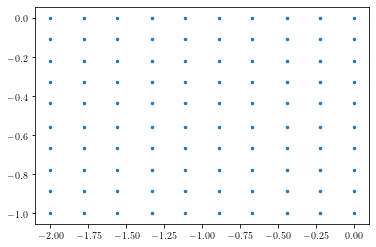

0
[-2.0, -1.0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
133.9738093741893
[-2.0, -1.0]
[ 0.011  0.009 -0.001  0.011  0.009 -0.001  0.011  0.009 -0.001  0.011
  0.009 -0.001  0.011  0.009 -0.001  0.011  0.009 -0.001  0.011  0.009
 -0.001  0.011  0.009 -0.001]
97.90026270036252
[-2.0, -1.0]
[-0.072 -0.006  0.    -0.072 -0.006  0.    -0.072 -0.006  0.    -0.072
 -0.006  0.    -0.072 -0.006  0.    -0.072 -0.006  0.    -0.072 -0.006
  0.    -0.072 -0.006  0.   ]
46.60256656917949
[-2.0, -1.0]
[-0.09  -0.008 -0.    -0.09  -0.008 -0.    -0.09  -0.008 -0.    -0.09
 -0.008 -0.    -0.09  -0.008 -0.    -0.09  -0.008 -0.    -0.09  -0.008
 -0.    -0.09  -0.008 -0.   ]
44.88044520210531
1
[-1.78, -1.0]
[-0.082 -0.004 -0.    -0.082 -0.004 -0.    -0.082 -0.004 -0.    -0.082
 -0.004 -0.    -0.082 -0.004 -0.    -0.082 -0.004 -0.    -0.082 -0.004
 -0.    -0.082 -0.004 -0.   ]
36.73736372149465
2
[-1.56, -1.0]
[-0.09  -0.001  0.    -0.09  -0.001  0.    -0.09  -0.001  0.   

In [40]:
# Load the Pandas libraries with alias 'pd' 
import numpy as np
import pandas as pd 
import matplotlib.colors as Colors
import matplotlib.pyplot as plt
import os
import cv2
import sys
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from scipy.stats import entropy
from os import listdir
from os.path import isfile, join
import math
from scipy.stats import chisquare
from scipy import stats
from itertools import product
import pickle
import random

np.set_printoptions(threshold=sys.maxsize)

def plotAllModelsObservables(models, coeffs):
    
    
    observables = loadObservables()
    
    numObservables = len(observables)
    nrows = math.ceil(numObservables/2)
    ncols = 2
    nrows =1
    ncols =1
    imageWidth = 6
    imageHeight = 5
    hspace = 0.5
    wspace = 0.5
    figureHeight = nrows * imageHeight + (nrows - 1) * hspace
    figureWidth = ncols * imageWidth + (ncols - 1) * wspace
    
    plt.rc('text', usetex=True)
    plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]    
    
    
    for C9, C10 in models:    
        index = 1
        fig, axs = plt.subplots(nrows,ncols)
        fig.subplots_adjust(left=None, right=None, bottom=None, top=0.90, hspace=hspace, wspace=wspace)  
        fig.set_figheight(figureHeight)
        fig.set_figwidth(figureWidth)
        #fig.delaxes(axs[2,2])
        axs = np.reshape(axs,(-1))
        axis_index = 0
        allFits=[]
        for mo, eo in observables:
            
            #fig.suptitle(title, fontsize=18) 
            df = mo['data']
            de = eo['data']
            
            ax = axs[axis_index]            
            
            observableName = mo['name']
            
            ax.set_xlabel(r'\(\boldsymbol{q^2(GeV^2)}\)', fontsize=16)
            print(observableName)
            if(observableName == 'RKStar'):
                ytitle = 'R'
                ax.set_ylabel(r'\(\langle \boldsymbol{{{}_K^*}} \rangle\)'.format(ytitle), fontsize=16)
            elif(observableName=='BRK0mumu'):
                ytitle = 'B'
                ax.set_ylabel(r'\(\langle \boldsymbol{{\mathcal{B}(B^0\rightarrow K\mu\mu)}} \rangle\)', fontsize=16)
            elif(observableName=='BRK0Starmumu'):
                ytitle = 'B'
                ax.set_ylabel(r'\(\langle \boldsymbol{{\mathcal{B}(B^0\rightarrow K^{*0}\mu\mu)}} \rangle\)', fontsize=16)
            elif(observableName == 'P5'):
                ytitle = 'P'
                ax.set_ylabel(r'\(\langle \boldsymbol{{{}_5}} \rangle\)'.format(ytitle), fontsize=16)
            elif(observableName == 'RK'):
                ytitle = 'R'
                ax.set_ylabel(r'\(\langle \boldsymbol{{{}_K}} \rangle\)'.format(ytitle), fontsize=16)
            else:
                ax.set_ylabel(r'\(\langle \boldsymbol{{{}}} \rangle\)'.format(observableName), fontsize=16)
                
            computeModelObservable(df, C9, C10)
            if(len(coeffs) > 0):
                addQPoly(df,coeffs[axis_index])
                
            fit = computeModelFit(df, de)
            print(fit)
            
            allFits.append(fit)
            #ax.set_title(r'\(\chi^2:{} \)'.format(round(fit,2)), fontsize=20)
            ax.set_xlim(0, max(df['BinHigh'].max(), de['BinHigh'].max()))
            ax.set_ylim([min(df['MinValue'].min(),de['MinValue'].min()), max(df['MaxValue'].max(),de['MaxValue'].max())+0.0051])
            
            plotObservable(ax, df, 'orange', 'black', 1)
            plotObservable(ax, de, 'black', 'green', 0, True, True)
            index = index + 1 
            
            axis_index = axis_index + 1
        #title = r'Model: C9: {}, C10: {}, \(\chi^2: {} \)'.format(round(C9,2), round(C10,2),round(np.array(allFits).sum(),3))         
        #fig.suptitle(title, fontsize=24) 
        fig.savefig('observableImages/{}.svg'.format('AllObservables'))
    plt.show()
   
    
    
def expandObservableData(df):
    df['Widths'] = df['BinHigh'] - df['BinLow']
    df['Heights'] = df['ErrorPlus'] + df['ErrorMinus']  
    
       

def plotObservable(ax, df, color,kcolor, opacity, yerrorbar = False, onlyErrorBars = False):   
    patches = [Rectangle((x,y), w, h) for x,y,w,h in zip(df['BinLow'], df['MinValue'], df['Widths'], df['Heights'])]
    xerror = [df['Widths'] / 2, df['Widths'] / 2]    
    
    if(not onlyErrorBars):
        p = PatchCollection(patches, facecolor=Colors.to_rgba(color, opacity))
        ax.add_collection(p)       
    ax.errorbar(df['BinLow'] + df['Widths']/2, df['BinValue'], xerr=xerror, fmt='None', ecolor=Colors.to_rgba(kcolor, 1))
    if(yerrorbar):
        yerror = [df['Heights'] / 2, df['Heights'] / 2] 
        ax.errorbar(df['BinLow'] + df['Widths']/2, df['BinValue'], yerr=yerror, fmt='None', ecolor=Colors.to_rgba(kcolor, 1))


def computePoly(binCoeffs,c9,c10):
    a = binCoeffs[0]
    b = binCoeffs[1]*c10
    c = binCoeffs[2]*c10**2
    d = binCoeffs[3]*c9
    e = binCoeffs[4]*c10*c9
    f = binCoeffs[5]*c9**2
    return a + b + c  + d + e + f

def getBinValuesFreeCoeffs(df, c9, c10, observableCoeffs):     
    df['BinValue'] = [computePoly(binCoeffs,c9,c10) for binCoeffs in observableCoeffs]
    
        
def getBinValues(df, C9, C10):     
    df2 = df.copy();       
    df2['C10'] = df2['C10']*C10
    df2['C10^2'] = df2['C10^2']*C10**2
    df2['C9'] = df2['C9']*C9
    df2['C10*C9']=df2['C10*C9']*C10*C9
    df2['C9^2'] = df2['C9^2']*C9**2    
    df['BinValue'] = df['C0'] + df2['C10'] + df2['C10^2'] + df2['C9'] + df2['C10*C9'] + df2['C9^2']
    df['MinValue'] = df['BinValue'] - df['ErrorMinus']
    df['MaxValue'] = df['BinValue'] + df['ErrorPlus']

def getModelObservable(DATADIR, filename) :
    return getObservable(DATADIR, filename)

def getExpObservable(DATADIR, filename) :
    eo = getObservable(DATADIR, filename)
    df = eo['data']
    df['MinValue'] = df['BinValue'] - df['ErrorMinus']
    df['MaxValue'] = df['BinValue'] + df['ErrorPlus']
    return eo

def getObservable(DATADIR, filename):
    try:  
        df = pd.read_csv(os.path.join(DATADIR, filename))
        expandObservableData(df)
        fname = filename.split('.')[0]  
        if(fname=='P1'):   
            print('')
            #df=df.drop([1])
        elif(fname=='P2'):
            print('')
            #df=df.drop([0])
        elif(fname=='P5'):
            print('')
            #df=df.drop([3,4,5])        
        return {'name': fname, 'data': df}
    except Exception as e:
        print(e)
        pass
    
def computeModelFit(dfm, dfe):
    data = zip(dfm['BinValue'], dfe['BinValue'], (dfm['ErrorPlus']+dfm['ErrorMinus'])/2, (dfe['ErrorPlus']+dfe['ErrorMinus'])/2)
    binFits = [computeChiSquare(muModel, muExp, sigmaModel, sigmaExp) for muModel, muExp, sigmaModel, sigmaExp in data]      
    s = sum(binFits)
    return s
        
def computeChiSquare(muModel, muExp, sigmaModel, sigmaExp):   
    return (muExp - muModel)**2/(sigmaModel**2 + sigmaExp**2)
    

def getObservables(DATADIR, EXPDIR, names):
    observables = []
    for filename in names:
        mo = getModelObservable(DATADIR, filename)        
        eo = getExpObservable(EXPDIR, filename)
        observables.append([mo, eo])
    return observables
    
def getAllObservables():
    DATADIR = 'data/models/observables' 
    EXPDIR = 'data/experimental'     
    onlyfiles = [f for f in listdir(DATADIR) if isfile(join(DATADIR, f))]    
    return getObservables(DATADIR, EXPDIR, onlyfiles)   

def computeRandomModelsFit(observables):    
    models = getRandomModels()
    return computeModelsFit(models, observables)    

def getCoeffsFromModels(models):
    m = [[c9, c10] for c9, c10 in zip(models['C9'], models['C10'])]
    return m
    
def getModels():
    MODELSDIR = 'data/models'  
    mfilename = 'models1.txt'    
    models = pd.read_csv(os.path.join(MODELSDIR, mfilename))
    return models

def addQPoly(dfe, coeffs):
    dfe['q^2'] = (dfe['BinHigh'] + dfe['BinLow']) / 2
    
    dfe['Fq^2Net'] = coeffs[0]  + coeffs[1] * dfe['q^2'] + coeffs[2] * dfe['q^2']**2
    
    dfe['BinValueOld'] = dfe['BinValue']
    dfe['BinValue'] = dfe['BinValue'] + dfe['Fq^2Net']  
    dfe['BinValueDiff'] = dfe['BinValue'] - dfe['BinValueOld']
    dfe['MinValue'] = dfe['BinValue'] - dfe['ErrorMinus']
    dfe['MaxValue'] = dfe['BinValue'] + dfe['ErrorPlus']
    
        
def computeModelObservable(df, C9, C10):
    getBinValues(df,C9, C10) 
    expandObservableData(df)

def getObservablesByName(DATADIR, EXPDIR, names):
    names = [f for f in listdir(DATADIR) if isfile(join(DATADIR, f)) and f.split('.')[0] in names]
    return getObservables(DATADIR, EXPDIR, names)     

    
def computeAllModelsAllFit():
    DATADIR = 'data/models/observables' 
    EXPDIR = 'data/experimental'  
    models = getModels()
    m = getCoeffsFromModels(models)
    observables = getAllObservables()
    #observables = getObservablesByName(DATADIR, EXPDIR, ['P5'])
    return computeModelsFit(m, observables)

def getValue(value, low, high ):    
    #print('value: {}, high: {}, low: {}, newValue: {}'.format(value,high,low, random.uniform(value - low, value + high)))
    return np.random.normal(value, low)

def generateExperimental():    
    observables = loadObservables()
    x = np.array([])
    for mo, eo in observables:
        dfe = eo['data']
        x = np.append(x, dfe['BinValue'].values)
        
    saveData("X_experimental.pickle", x)
    return x

def saveData(filename, data):
    pickle_out = open(filename, "wb")
    pickle.dump(data, pickle_out)
    pickle_out.close()         

    
def generateBinErrors():
    observables = loadObservables() 
    
    errors = np.empty([0,6]);
    for mo, eo in observables:
        
        dfm = mo['data']
        dfe = eo['data']
        expandObservableData(dfm)
        expandObservableData(dfe)
        dfmErrorMinus = dfm['ErrorMinus']  
        dfeErrorMinus = dfe['ErrorMinus']  
        dfmError = dfm['Heights'].values / 2
        dfeError = dfe['Heights'].values / 2
        widths = dfe['Widths'].values
        bins = dfm['BinLow'].values
        errors = np.append(errors, [[a,b,c,d,e,f] for a,b,c,d,e,f in zip(dfmError,dfeError,widths,bins,dfmErrorMinus,dfeErrorMinus)],axis=0)
     
    saveData("errors.pickle", errors)
    

def generateObservableNumBins():
    observables = loadObservables() 
    
    numBins = []
    for mo, eo in observables:
        dfe = eo['data']
        numBins.append(len(dfe.index))
     
    saveData("numBins.pickle", numBins)
    print(numBins)


    
def genNNData():
    observables = loadObservables()  
    models = getRandomModels()
   
    X = []
    Y = []
    coeffs = []
    iter=0   
    bestFit=100000
    bestc=[]
    allFits=[]
    for c9, c10 in models:
        print(iter)
        iter=iter+1             
            
       
        x = []
        y = np.array([])

        fits=[]        

        for mo, eo in observables:
            dfm = mo['data']
            dfe = eo['data']                

            computeModelObservable(dfm,c9, c10)


            fit = computeModelFit(dfm, dfe)
            fits.append(fit)                

            #x = x + dfm['BinValue'].values.tolist()          


        y = np.append(y,[c9,c10])     
       
        fit = np.array(fits).sum()
        allFits.append(fit)
     
        if(fit<bestFit):
            bestFit=fit
            bestc = [c9,c10]
            print(bestc)
            print(fit)
            
        # FOR GAN -----------------------------
        x = x + [c9,c10]
        x = x + [fit]
        #--------------------------------------
        X.append(x)
        
        Y.append(y.tolist()) 
            
        
    
    generateExperimental()
    X = np.array(X)
    Y = np.array(Y)  
    
    
    saveData("X_NN.pickle", X)
    saveData("y_NN.pickle", Y)
    saveData("histLogChisquare.pickle", allFits)
    
    print(bestFit)
    print(bestc)
    print(X[0])
    
    
def genNNWithCoeffsData():
    observables = loadObservables()  
    models = getRandomModels()
   
    X = []
    Y = []
    coeffs = []
    numPolyCoeffs = 100
    iter=0   
    bestFit=100000
    bestq=[]
    bestc=[]
    for c9, c10 in models:
        print(iter)
        iter=iter+1        
        
        for i in range(numPolyCoeffs):  
            
            allFits = []      
            x = []
            y = np.array([])
            allQSquareCoeffs = np.array([])            
            fits=[]
            numObs = 0
            if(i==0):
                QSsquareCoeffs = np.random.uniform(0, 0, 3)                
            else:
                QSsquareCoeffs = [rnd() for _ in range(3)]
                QSsquareCoeffs[1] = QSsquareCoeffs[1]/10
                QSsquareCoeffs[2] = QSsquareCoeffs[2]/100
                QSsquareCoeffs = np.round(QSsquareCoeffs,3)


                
            for mo, eo in observables:
                dfm = mo['data']
                dfe = eo['data']                
                allQSquareCoeffs = np.append(allQSquareCoeffs, QSsquareCoeffs)         
                computeModelObservable(dfm,c9, c10)
                
                   
                addQPoly(dfm, QSsquareCoeffs)                
                fit = computeModelFit(dfm, dfe)
                fits.append(fit)                
                
                x = x + dfm['BinValue'].values.tolist()
                numObs = numObs + 1
                
            
            y = np.append(y,[c9,c10])     
            y = np.append(y, allQSquareCoeffs)
            fit = np.array(fits).sum()
            if(fit<bestFit):
                bestFit=fit
                bestc = [c9,c10]
                bestq = allQSquareCoeffs
                print(bestc)
                print(bestq)
                print(fit)
                
            # for GAN
            
            x = x + [c9,c10]
            
            x = x + allQSquareCoeffs.tolist()
            
            x = x + [round(fit,2)]
            #x = x + [0]
            
            #-----------------------------------
            
            X.append(x)
           
            #X.append(x + [fit])
            
            
            Y.append(y.tolist()) 
            
        
    
    generateExperimental()
    X = np.array(X)
    Y = np.array(Y)  
    
    
    saveData("X_NN_With_Coeffs.pickle", X)
    saveData("y_NN_With_Coeffs.pickle", Y)
    
    saveData("coeffs_noChi.pickle", coeffs)  
    print(bestFit)
    print(bestc)
    print(bestq)
    

    
def loadObservables():
    DATADIR = 'data/models/observables' 
    EXPDIR = 'data/experimental'  
    observables = []
    
    P1 = getObservablesByName(DATADIR, EXPDIR, ['P1'])
    P2 = getObservablesByName(DATADIR, EXPDIR, ['P2'])
    P4 = getObservablesByName(DATADIR, EXPDIR, ['P4'])
    P5 = getObservablesByName(DATADIR, EXPDIR, ['P5'])
    BRK0Starmumu = getObservablesByName(DATADIR, EXPDIR, ['BRK0Starmumu'])
    BRK0mumu = getObservablesByName(DATADIR, EXPDIR, ['BRK0mumu'])
    RK = getObservablesByName(DATADIR, EXPDIR, ['RK'])
    RKStar = getObservablesByName(DATADIR, EXPDIR, ['RKStar'])    
    #
    observables = np.array([P1, P2, P4, P5, BRK0Starmumu, BRK0mumu, RK, RKStar])
    observables = observables.reshape((8,2))
    
    #observables = np.array([RK])
    #observables = observables.reshape((1,2))
    
    
    #observables = np.array([P1])
    #observables = observables.reshape((1,2))
    return observables

    
def getRandomModels():
    c9 = np.round(np.linspace(-2, 0, num=10), 2)
    c10 = np.round(np.linspace(-1, 0, num=10), 2)    
    #c9 = np.round(np.linspace(-5, 5, num=10), 2)
    #c10 = np.round(np.linspace(-5, 5, num=10), 2)    
    models = np.meshgrid(c9, c10)    
    
    r = np.array([(x,y) for a,b in zip(models[0], models[1]) for x,y in zip(a,b)]) 
    #r = np.array([(x,y) for x,y in zip(c9,c10)])      
    area = np.pi*2
    # Plot
    plt.scatter(r[:,0], r[:,1], s=area, alpha=1)
    plt.show() 
    return r   

def generateNearZeroSamples(num):
    result =[]
    pickle_in = open("X_experimental.pickle", "rb")
    X_experimental = pickle.load(pickle_in)


    pickle_in = open("errors.pickle", "rb")
    errors = pickle.load(pickle_in)
    errors= np.array(errors[:,1])
    Y = []
    
    for i in range(num):    
        newSample = np.random.normal(X_experimental, 0.1)
        f = computeModelFit2(newSample, X_experimental,errors,errors)    
        Y.append(int(round(f)))
        result.append((newSample).tolist())
    
    saveData("X_NearZero_experimental.pickle", result)
    saveData("y_NearZero_experimental.pickle", Y)
    return result
  
def computeModelFit2(bins,binsExp,errorModel, errorExp):
    
    binFits = [computeChiSquare(muModel, muExp, errorModel, errorExp) for muModel, muExp, errorModel, errorExp in zip(bins,binsExp,errorModel,errorExp)]      
    s = sum(binFits)
    return s
    
def rnd():
    exp = random.randint(-19, -15)
    base = 10 * random.random() - 1
    #return base * 10**exp
    #return random.random()
    
    return round(random.uniform(-.1, .1),3)
    


def computeModelCoeffsFit(coeffs, q2coeffs):
    observables = loadObservables() 
    c9, c10 = coeffs[0]
    fits=[]
    numObs = 0
    for mo, eo in observables:
        dfm = mo['data']
        dfe = eo['data'] 
        computeModelObservable(dfm,c9, c10)

        if(len(q2coeffs) > 0):
            
            addQPoly(dfm, q2coeffs[numObs])

        fit = computeModelFit(dfm, dfe)
        
        fits.append(fit)
        numObs = numObs+1
        
    return np.array(fits).sum()
        
        

   
#computeAllModelsAllFit()
#computeRandomModelsFit(getObservablesByName('data/models/observables' ,'data/experimental', observableNames))
#print(computeModelsLFUVFit())
#observableNames = ['P1', 'P2', 'P4', 'P5', 'BRK0Starmumu', 'BRK0mumu', 'RK', 'RKStar']
#r = computeModelsFit([[-0.2,  0.002]], getObservablesByName('data/models/observables' ,'data/experimental', observableNames))
#print(r)
#getObservablesByName('data/models/observables','data/experimental/' ,['P1', 'P2'])
#getRandomModels()
#generateNNData()
#generateGANData()
#generateExperiment1GANData()

#generateExperimental()

# Pass 2d array of coeffs ex: [[-0.5, 0.5], [-1, 0]]
#plotAllModelsObservables(getCoeffsFromModels(getModels()),[])
#generateTrueImages()
#generateTestData()
#getRandomModels()

#generateNearZeroSamples(500)
#generateGANData()


#generateGANData3()
#generateBinErrors()
#generateObservableNumBins()

#generateNearZeroSamples(1)
#genNNData()
genNNWithCoeffsData()
#plotAllModelsObservables([[-0.5,0.5 ]],[])

#a = [-1.5  , 0 ,  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#a=[-3.54 , 2.16 , 3.7336019e-06 , 1.6394207e-11,
#   1.4970936e-10]
#a=[-1.7165524e+01, -6.6029954e-01,  1.5080704e-07 , 6.0016580e-14,
#   7.8496305e-07]
#a=[-8.8368118e-02 , 3.6405189e+00  ,1.3597724e-04, -2.5137824e-06,
#   3.4012530e-08]
#a = [-1.33, -0.44,-0.093,  0.001,  0.,    -0.093,  0.001,  0.,    -0.093 , 0.001 , 0. ,   -0.093,
#  0.001 , 0. ,   -0.093,  0.001 , 0.  ,  -0.093,  0.001 , 0. ,   -0.093 , 0.001,
#  0.  ,  -0.093 , 0.001 , 0.   ]
#
#
#c_coeffs = a[0:2]
#q_coeffs = np.reshape(a[2:],(8,3))
##print(np.round(q_coeffs,2))
##q_coeffs = []
#plotAllModelsObservables([c_coeffs], q_coeffs)
#c_coeffs=[0,0]
#q_coeffs = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#q_coeffs = np.reshape(q_coeffs,(8,3))
#computeModelCoeffsFit([c_coeffs], [])

In [17]:
a=[1,2]
b=[3,4,5]
a+b

[1, 2, 3, 4, 5]

In [18]:
random.uniform(-10, 10)

-0.10234708281720373

In [19]:
random.random([-5,5])

TypeError: random() takes no arguments (1 given)

In [ ]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import matplotlib.colors as Colors
from matplotlib.patches import Polygon
plt.rc('text', usetex=True)
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]    
def plotObservable2(ax, binValues, bins, binWidths, binValuesErrors, color,kcolor):   
    # Set height minimum
    binValuesErrors = [0.01 if a_ < 0.01 else a_ for a_ in binValuesErrors]
    patches = [Rectangle((x,y), w, h) for x,y,w,h in zip(bins,binValues, binWidths, binValuesErrors)]
       
    p = PatchCollection(patches, facecolor=Colors.to_rgba(color, 1))    
    ax.add_collection(p)


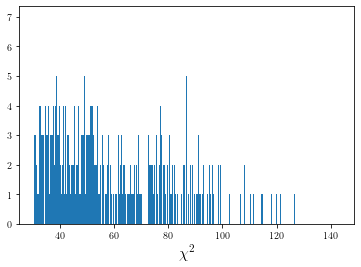

In [20]:
pickle_in = open("histLogChisquare.pickle", "rb")
histLogChisquare = pickle.load(pickle_in)
histLogChisquare = np.array(histLogChisquare)

plt.rc('text', usetex=True)
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]  
bin_edges = np.linspace(start= histLogChisquare.min(), stop=histLogChisquare.max()+1, num=np.unique(histLogChisquare).size+1, endpoint=True)

plt.hist(histLogChisquare, bin_edges) 
plt.xlabel(r'\(\chi^2 \)', fontsize=16)
plt.savefig('histChisquare.svg')
plt.show()


In [ ]:
from collections import Counter
pickle_in = open("X_noChi.pickle", "rb")
X_train = pickle.load(pickle_in)

pickle_in = open("y_noChi.pickle", "rb")
y_train = pickle.load(pickle_in)

pickle_in = open("coeffs_noChi.pickle", "rb")
coeffs = pickle.load(pickle_in)
print(y_train.shape)
print(X_train.shape)
print(len(Counter(y_train).keys()))
print(max(y_train))
print(min(y_train))
#print(X_train[1000:2000,-2:])
#print(X_train[np.where(y_train==min(y_train))])
#print(coeffs[np.where(y_train==min(y_train))])


## Simple Neural Network

In [ ]:
def saveData(filename, data):
    pickle_out = open(filename, "wb")
    pickle.dump(data, pickle_out)
    pickle_out.close()   

In [ ]:
#Dependencies
import time
import tensorflow as tf
import pickle
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
#-------------------------------------------------------------
#NN 1 data
pickle_in = open("X_NN.pickle", "rb")
X_train = pickle.load(pickle_in)
print(X_train.shape)
pickle_in = open("y_NN.pickle", "rb")
y_train = pickle.load(pickle_in)


#NN 2 data
#pickle_in = open("X_NN_With_Coeffs.pickle", "rb")
#X_train = pickle.load(pickle_in)
#
#pickle_in = open("y_NN_With_Coeffs.pickle", "rb")
#y_train = pickle.load(pickle_in)
#print(X_train.shape)
##
pickle_in = open("X_experimental.pickle", "rb")
X_experimental = pickle.load(pickle_in)

#-------------------------------------------------------------
#scaler = StandardScaler()
## fit scaler on data
#scaler.fit(X_train)
## apply transform
#X_train = scaler.transform(X_train)
#-------------------------------------------------------------
early_stop = EarlyStopping(monitor='val_mean_squared_error', mode='min', patience=10)
NAME = "NN-{}".format(int(time.time()))
tensorBoard = TensorBoard(log_dir='logs/{}'.format(NAME))


pp=[]
#model.summary()
highest_fit = 100000000
highest_coefs = []
#scaler.fit([X_experimental])
#X_experimental = scaler.transform([X_experimental])
for i in range(1):
    print(i)
    model = Sequential()
    model.add(Dense(500, input_dim=37, activation='relu')) 
    model.add(Dense(500, activation='relu'))
    model.add(Dense(780, activation='relu'))
    #-------------------------------------------------------------
    # Output for NN1
    model.add(Dense(2))
    # Output for NN2
    #model.add(Dense(26))
    #--------------------------------------------------------------

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.MeanSquaredError()])
    history = model.fit(X_train, y_train, batch_size=512, epochs=200, validation_split=0.1, callbacks=[tensorBoard,early_stop], verbose=1,shuffle=True)
    
    #p = model.predict(np.reshape(np.append(X_experimental[0:6],[0]),(1,7)))
    #p = model.predict(np.reshape(np.append(X_experimental,[0]),(1,38)))
    p = model.predict(np.reshape(X_experimental,(1,37)))
    #q_coeffs = np.reshape(p[0][2:],(8,3) )
    fit = computeModelCoeffsFit([p[0][0:2]],[])
    
    if(fit<highest_fit):
        highest_fit = fit
        highest_coefs = p
        print(fit)
    
    
#
    pp.append(p);
print(highest_fit)
print(highest_coefs)

    
pp = np.array(pp)
saveData('pp.pickle', pp)

#scaler.fit([X_experimental])
## apply transform
#X_experimental = scaler.transform([X_experimental])
#p = model.predict(np.reshape(np.append(X_experimental[0:6],[0]),(1,7)))
#
#print(p)

In [ ]:

computeModelCoeffsFit([[-1,0]], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])

In [ ]:
pickle_in = open("X_experimental.pickle", "rb")
X_experimental = pickle.load(pickle_in)
print(np.array(X_experimental).shape)

In [ ]:

pickle_in = open("X_NN.pickle", "rb")
X = pickle.load(pickle_in)
print(X)

In [ ]:
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
pickle_in = open("pp.pickle", "rb")
pp = pickle.load(pickle_in)
print(pp)
pp = np.reshape(pp, (100,2))
xedges = [-2,-1, 0, 1, 2]
yedges = [-2,-1, 0, 1, 2]
H, xedges, yedges = np.histogram2d(pp[:,0], pp[:,1], bins=(xedges, yedges))

fig = plt.figure(figsize=(15, 10))


ax = fig.add_subplot()
ax.set_xlabel(r'\(C_{9}\)',fontsize=48, labelpad=30)
ax.set_ylabel(r'\(C_{10}\)',fontsize=48, labelpad=10)
ax.set_xticks(np.arange(-2, 2,0.5))
ax.set_yticks(np.arange(-2, 2,0.5))

plt.imshow(H, interpolation='nearest', origin='low',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.colorbar()
plt.savefig('predictedCoeffs.svg')

In [ ]:
plt.rc('text', usetex=True)
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel(r'\(\boldsymbol{C_{10}}\)', fontsize=16)
ax.set_xlabel(r'\(\boldsymbol{C_{9}}\)', fontsize=16)
h = ax.hist2d(x, y, bins=10)
fig.colorbar(h[3], ax=ax)
plt.show()
fig.savefig('NN_predictions.svg')
print(type(h))

## Adversarial NN

## Linear Regression

## MultiOutput Regressor

### Generate images

### Simple NN one sigmoid, binary_crossentropy

### Simple Neural Netwok 2 sigmoids, categorical_crossentropy

### Simple NN one softmax, categorical_crossentropy

### CNN